## CS310 Natural Language Processing
## Lab 5 (part 2): Data preparation for implementing an RNN Language Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Process input sequences of variable lengths

When training RNN (LSTM or vanilla-RNN), it is difficult to batch the variable length sequences. 

For example: if the length of sequences in a size 8 batch is `[4,6,8,5,4,3,7,8]`, you will pad all the sequences and that will result in 8 sequences of length 8. You would end up doing 64 computations (8x8), but you needed to do only 45 computations. 

PyTorch allows us to pack the sequence, internally packed sequence is a tuple of two lists. One contains the elements of sequences. Elements are interleaved by time steps (see example below) and other contains the size of each sequence the batch size at each step. 

This is helpful in recovering the actual sequences as well as telling RNN what is the batch size at each time step. 

在 RNN 训练中，批次（batch）通常会包含多个序列。通常情况下，我们希望将多个序列一起处理，以便于并行计算。然而，序列的长度通常是不一样的。
Padding：为了使批次中的所有序列有相同的长度，我们通常会使用填充（padding）。比如，如果批次中有序列长度分别为 [4, 6, 8, 5, 4, 3, 7, 8]，为了使所有序列的长度一致，我们会将它们填充到最大长度（这里是 8），这样每个序列就会变成长度 8。经过填充后，所有序列的长度一致，但我们实际上并不需要填充的部分进行计算。
为了解决这个问题，PyTorch 提供了 pack_padded_sequence 函数，允许我们打包变长序列。这样做的好处是，序列的实际数据（非填充部分）会被保留下来，而填充部分不会被传递到模型中进行计算。

Packed sequence 实际上是一个包含两个部分的元组（tuple）：
序列数据（Elements）：这部分包含所有时间步的序列数据，但所有序列的数据会按时间步交替排列。例如，对于一个大小为 8 的批次，原始序列长度为 [4,6,8,5,4,3,7,8]，这会被处理成一个长序列，按时间步依次排列。
每个时间步的批次大小：这部分包含每个时间步的有效序列的批次大小。由于每个序列的长度不同，我们需要知道每个时间步有效的批次大小（即未填充部分的序列数）。这样 RNN 才能知道在每个时间步哪些序列有效。

**Example**:

In [ ]:
seqs = [torch.tensor([1,2,3]), torch.tensor([3,4])] # Sequences
seq_lens = torch.tensor([3,2]) # Actual lengths of sequences

# First, pad the sequences to the same length
padded_seqs = nn.utils.rnn.pad_sequence(seqs, batch_first=True) # batch_first=True 表示输出张量的第一维是批次大小(batch_size, max_sequence_length)；否则是序列长度(max_sequence_length, batch_size)

# Then pack them all before passing to the RNN
packed_seqs = nn.utils.rnn.pack_padded_sequence(padded_seqs, seq_lens, batch_first=True, enforce_sorted=False)

# Print intermediate results
print('original sequences:', seqs)
print('padded sequences:', padded_seqs)
print('packed sequences:', packed_seqs)
# 输出的batch_sized是每个时间步的有效批次大小，最后一次只有第一个序列有值

original sequences: [tensor([1, 2, 3]), tensor([3, 4])]
padded sequences: tensor([[1, 2, 3],
        [3, 4, 0]])
packed sequences: PackedSequence(data=tensor([1, 3, 2, 4, 3]), batch_sizes=tensor([2, 2, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1]))


Note that 
- Default padding ID is 0
- The padded sequence is of shape `batch_size x max_length`. Assuming it is word ids, then after it is embedded, it will be of shape `batch_size x max_length x embedding_size`. 
- Here, `max_length` is the length of the longest sequence in the batch. 
- We set `enforce_sorted` to `False` in `pack_padded_sequence` because we are not sorting the sequences by length. 

---

In the next cell, we will first embed the padded sequence (integer word ids) and then pack the embedded sequence. 

It is the packed embedded sequence that we pass to RNN. It will internally unpack the sequences and compute only the necessary time steps.   

To examine the output, you need to unpack it, which is a reverse process of packing.

In [ ]:
embedding = nn.Embedding(5, 10) # 5 表示词汇表大小（即有 5 个不同的单词），10 表示每个单词的嵌入向量维度是 10
# 由整数单词 ID 的张量转换为嵌入向量的张量
rnn = nn.RNN(10, 20, batch_first=True) # 10 是输入维度（与嵌入维度一致），20 是隐藏状态的维度

with torch.no_grad():
    padded_embs = embedding(padded_seqs)
    packed_embs = nn.utils.rnn.pack_padded_sequence(padded_embs, seq_lens, batch_first=True, enforce_sorted=False)

    out_packed, _ = rnn(packed_embs)
    out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
    # 打包后的输出（out_packed）是压缩格式，不便于直接查看或后续处理。解包将其还原为填充后的格式。

print('padded emb dim:', padded_embs.size())
print('packed output dim:', out_packed.data.size())
print('unpacked output', out_unpacked.size())

padded emb dim: torch.Size([2, 3, 10])
packed output dim: torch.Size([5, 20])
unpacked output torch.Size([2, 3, 20])


Note that 
- `pad_packed_sequence` does the reverse of `pack_padded_sequence`.
- the unpacked output is of shape `batch_size x max_length x hidden_size`, in which the first dimensions match the shape of the padded input sequences.

---

## T1. Practice Padding and Packing

First, Read all text data and build the vocabulary. 

Note that this time the ids for actual words will start from 1, as 0 will be used for padding, i.e., the special token '[PAD]'.

In [5]:
input_file = 'lunyu_20chapters.txt'

# You can use the code from previous lab or rewrite it
# Hint: you can comment out the `self.initTableNegatives()` in `__init__` method
from utils import CorpusReader
corpus = CorpusReader(inputFileName=input_file, min_count=1)

### START YOUR CODE ###
# Modify word2id to make 0 as the padding token '[PAD]', and increase the index of all other words by 1
# Modify the id2word list to make the first word '[PAD]' as well
# Hint: Both word2id and id2word in utils.CorpusReader are dict objects
word2id: dict = corpus.word2id
id2word: dict = corpus.id2word

new_word2id = {'[PAD]': 0}
new_id2word = {0: '[PAD]'}

for word, idx in word2id.items():
    new_word2id[word] = idx + 1
    new_id2word[idx + 1] = word

word2id = new_word2id
id2word = new_id2word

### END YOUR CODE ###

# Test result
print('id2word:', sorted(list(id2word.items()), key=lambda x: x[0])[:5])
print('word2id:', sorted(list(word2id.items()), key=lambda x: x[1])[:5])

# You should expect to see:
# id2word: [(0, '[PAD]'), (1, '，'), (2, '子'), (3, '。'), (4, '：')]
# word2id: [('[PAD]', 0), ('，', 1), ('子', 2), ('。', 3), ('：', 4)]

Total vocabulary: 1352
id2word: [(0, '[PAD]'), (1, '，'), (2, '子'), (3, '。'), (4, '：')]
word2id: [('[PAD]', 0), ('，', 1), ('子', 2), ('。', 3), ('：', 4)]


Read the first 16 lines of text, and convert them into integer sequences (`torch.Long`) of variable lengths. 

Then, follow the steps of `pad -> embed -> pack` to obtain the packed embedded sequence. 

Pass it to the RNN and then unpack the output.

*Hint*:
- You need to define the `embedding_lunyu` as an `nn.Embedding` object, with the correct vocabulary size and **embedding size of 50**.
- Create the `rnn_lunyu` as an `nn.RNN` object, with the correct input size and **hidden size of 100**.

In [6]:
text = []
with open(input_file, 'r', encoding='utf-8') as f:
    count = 0
    for line in f:
        text.append(list(line.strip()))
        count += 1
        if count >= 16:
            break

### START YOUR CODE ###
seq_ids = []
seq_lens = []
for line in text:
    ids=[word2id.get(word, 0) for word in line]
    seq_ids.append(ids)
    seq_lens.append(len(ids))

maxlen = max(seq_lens)
seq_ids_padded = torch.zeros((16,maxlen),dtype=torch.long)
for i, (ids, length) in enumerate(zip(seq_ids, seq_lens)):
    seq_ids_padded[i, :length] = torch.tensor(ids, dtype=torch.long)
### END YOUR CODE ###

# Define the embedding and RNN layers
### START YOUR CODE ###
embedding_lunyu =nn.Embedding(len(word2id), 50)
rnn_lunyu = nn.RNN(50, 100, batch_first=True)
### END YOUR CODE ###

# Create packed embedded sequence and feed it to the RNN
### START YOUR CODE ###
seq_embs = embedding_lunyu(seq_ids_padded)
seq_embs_packed = nn.utils.rnn.pack_padded_sequence(seq_embs, seq_lens, batch_first=True, enforce_sorted=False)

out_packed, _ = rnn_lunyu(seq_embs_packed)
out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
### END YOUR CODE ###

# Test result
print('seq_ids_padded:', seq_ids_padded.size())
print('seq_embs:', seq_embs.size())
print('out_unpacked:', out_unpacked.size())

# You should expect to see:
# seq_ids_padded: torch.Size([16, 85])
# seq_embs: torch.Size([16, 85, 50])
# out_unpacked: torch.Size([16, 85, 100])

seq_ids_padded: torch.Size([16, 85])
seq_embs: torch.Size([16, 85, 50])
out_unpacked: torch.Size([16, 85, 100])


## T2. Produce output from RNN hidden states

Lastly, generate output from the RNN hidden states. Each step of the hidden state sequence maps to a probability distribution over the vocabulary.

*Hint*:
- Define a linear layer `fc` with the correct input (hidden size of RNN) and output size (vocabulary size).
- The output of `fc` will be of shape `batch_size x max_length x vocab_size`, which we call `logits`.
- `logits` are not normalized, so you need to apply `F.log_softmax` to get the log probabilities.

In [ ]:
### START YOUR CODE ###
fc = nn.Linear(100, len(word2id))
logits = fc(out_unpacked)
log_probs = F.log_softmax(logits, dim=-1)# 在最后一个维度（词汇表）上应用 log_softmax
### END YOUR CODE ###

# Test result
print('logits:', logits.size())
print('log_probs:', log_probs.size())

# You should expect to see:
# logits: torch.Size([16, 85, 1353])
# log_probs: torch.Size([16, 85, 1353])

logits: torch.Size([16, 85, 1353])
log_probs: torch.Size([16, 85, 1353])


## T3. Prepare Target Labels

Prepare the target labels for the RNN. The target labels are the same as the input sequences, but shifted by one time step.

For example, if the input sequences is `[[1, 2, 3], [3, 4, 0]]`, the target labels should be `[[2, 3, 0], [4, 0, 0]]`, where 0 is the padding ID.

In this practice, you need to prepare the target labels for first 16 lines, i.e., `seq_ids_padded`
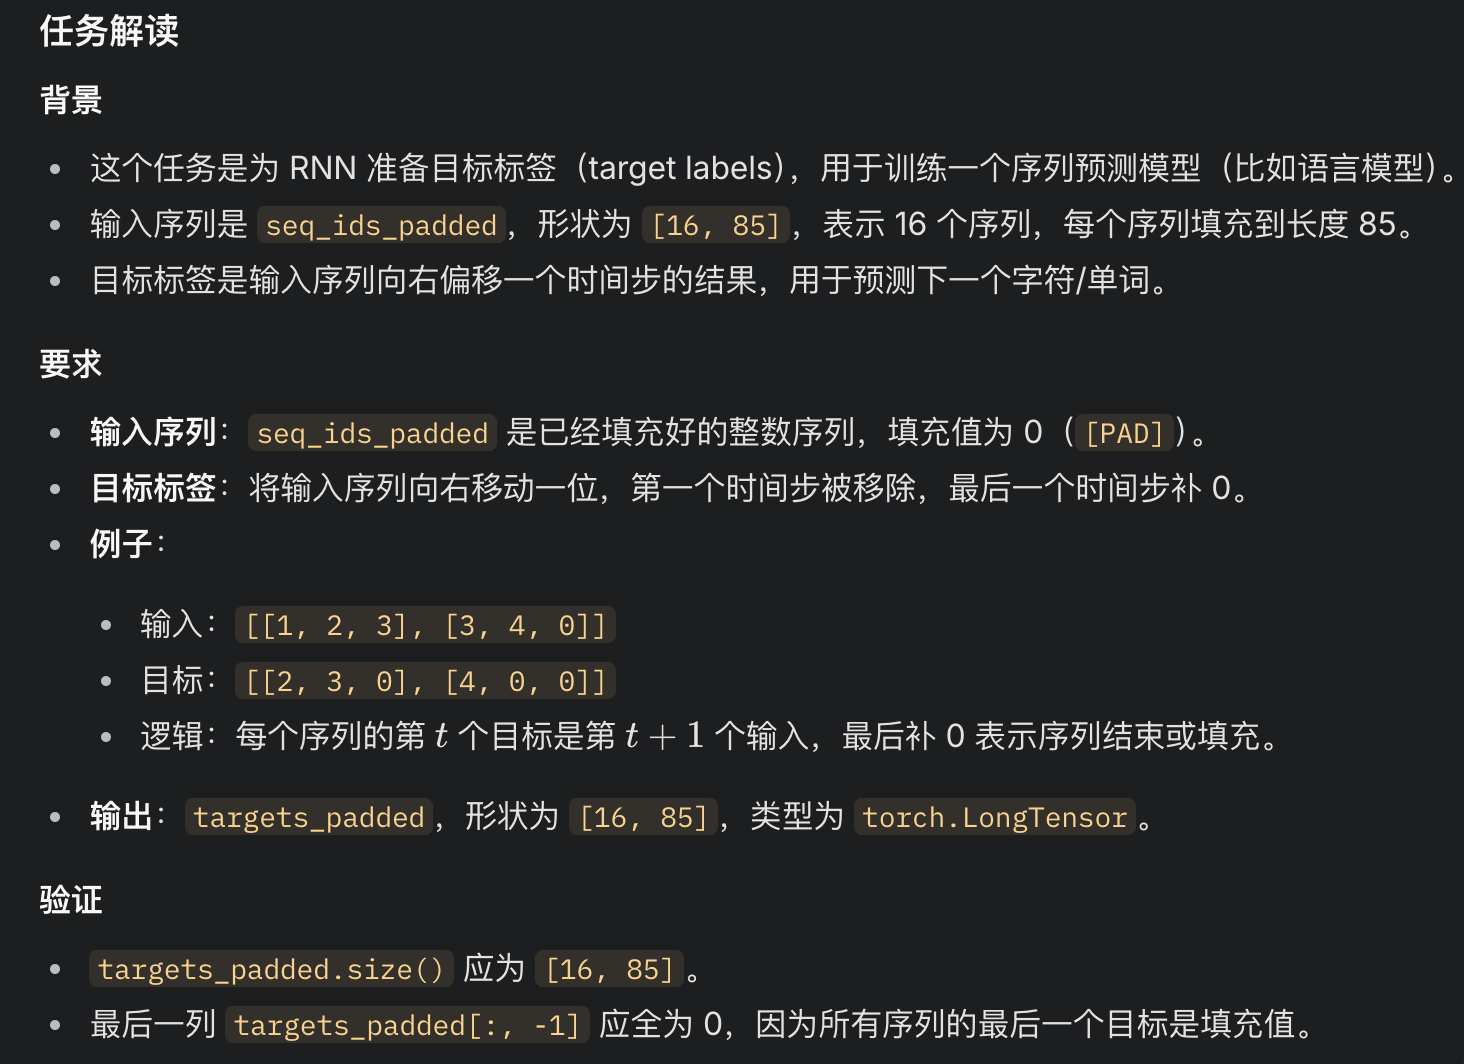

In [8]:
### START YOUR CODE ###
targets_padded = torch.zeros_like(seq_ids_padded)
targets_padded[:, :-1] = seq_ids_padded[:, 1:]  # 将输入的第 1 到最后一位复制到目标的第 0 到倒数第二位
### END YOUR CODE ###

# Test result
print('targets_padded:', targets_padded.size())
print('last column of targets_padded:', targets_padded[:, -1])

# You should expect to see:
# targets_padded: torch.Size([16, 85])
# last column of targets_padded: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

targets_padded: torch.Size([16, 85])
last column of targets_padded: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## T4. Compute Perplexity

In order to compute the perplexity, we first need to compute the negative log probabilities.

This can be accomplished by using the `nn.NLLLoss` function, which takes the `log_probs` and the `target_labels` as input, and the negative log probability (cross-entropy) loss, averaged over all the non-padding tokens: $-\sum \log(p)$

However, the default output of `nn.NLLLoss` is reduced to the average over all the tokens, including the padding tokens. We need to exclude the padding token by setting the `ignore_index` argument to the padding ID, i.e., 0. Also, set the `reduction` argument to `'none'` to get the loss for each non-padding token.

Finally, compute the perplexity by exponentiating the average loss per sequence.

See the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html


In [9]:
loss_fn = nn.NLLLoss(ignore_index=0, reduction='none')

### START YOUR CODE ###
# Calculate the loss
with torch.no_grad():
    log_probs_permuted = log_probs.permute(0, 2, 1)  
    log_probs_flat = log_probs_permuted.reshape(-1, len(word2id)) 
    targets_flat = targets_padded.reshape(-1) 
    loss = loss_fn(log_probs_flat, targets_flat)  
### END YOUR CODE ###

# Test result
print('loss:', loss.size())

# You shoul expect to see:
# loss: torch.Size([1360])
# Here, 1360 = 16 * 85, i.e., the total number of tokens in the batch

loss: torch.Size([1360])


## Model Architecture

In `__init__` method, initialize `word_embeddings` with a pretrained embedding weight matrix loaded. For example, the one obtained from previous assignment (saved word2vec file). 

`nn.Embedding` has a method `from_pretrained` that takes the pretrained weight matrix (a `numpy.ndarray` object) to initialize its weight.

`forward` method takes the word id sequences and sequence lengths as inputs, and return the logits or log probabilities from RNN. 

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, word_embeddings=None):
        super(RNNLM, self).__init__()
        if word_embeddings is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        ### START YOUR CODE ###
        self.rnn = None
        self.fc = None
        ### END YOUR CODE ###

    def forward(self, seq, seq_lens):
        ### START YOUR CODE ###
        pass
        ### END YOUR CODE ###

## Sentence Generation

After training the RNN, we can use it to generate sentences. 

The process is as follows:
- Start with a special token or a sequence of tokens, e.g., ["子", "曰"]
- Pass the sequence to the RNN, and sample the next word from the output probability distribution of the last time step. We use greedy search here, i.e., select the word with the highest probability.
- Append the sampled word to the sequence, and repeat the process until a special token, e.g., "。", is sampled; Or until it reaches the maximum length of generation.